# Exercício 1 — Barra 1D com carga distribuída (PINN)

Este notebook resolve o problema da barra engastada com carga distribuída \( q(x) = Cx \), utilizando redes neurais informadas por física (PINNs) com a biblioteca DeepXDE.

A equação diferencial que rege o sistema é:

\[
\frac{d}{dx}\left(EA \frac{du}{dx}\right) = Cx
\]

Com as condições de contorno de Dirichlet:

\[
u(0) = 0, \quad u(L) = \frac{CL^3}{3EA}
\]

A solução analítica é:

\[
u(x) = \frac{C}{EA} \left(\frac{L^2 x}{2} - \frac{x^3}{6} \right)
\]

Serão apresentados:
- Estrutura da rede utilizada
- Comparação entre a solução analítica e a PINN
- Erro absoluto médio
- Gráficos de comparação e perda


In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from deepxde.backend import tf

# Parâmetros físicos
C = 10     # N/m²
EA = 1     # módulo de elasticidade vezes área da seção
L = 5      # comprimento da barra


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Definição da equação diferencial
def pde(x, u):
    du_x = dde.grad.jacobian(u, x, i=0, j=0)
    d2u_xx = dde.grad.hessian(u, x, i=0, j=0)
    return EA * d2u_xx + (-C * x[:, 0:1])  # forma rearranjada da EDO


In [3]:
# Domínio espacial
geom = dde.geometry.Interval(0, L)

# Condições de contorno
def u0(x):
    return np.zeros((len(x), 1))

def uL(x):
    return (C / (3 * EA)) * L**3 * np.ones((len(x), 1))

bc1 = dde.DirichletBC(geom, u0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 0))
bc2 = dde.DirichletBC(geom, uL, lambda x, on_boundary: on_boundary and np.isclose(x[0], L))


In [4]:
# Definindo os dados do problema
data = dde.data.PDE(
    geom, pde, [bc1, bc2],
    num_domain=100,
    num_boundary=10,
    solution=None,
    num_test=1000
)

# Rede neural: 1 entrada, 3 camadas escondidas de 50 neurônios, 1 saída
net = dde.maps.FNN([1] + [50]*3 + [1], activation="tanh", kernel_initializer="Glorot normal")



# Modelo
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Refinamento com L-BFGS
model.compile("L-BFGS")
model.train()


Compiling model...
'compile' took 5.130208 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.97e+02, 0.00e+00, 1.74e+05]    [8.30e+02, 0.00e+00, 1.74e+05]    []  
1000      [1.03e+03, 5.43e+00, 1.29e+05]    [1.09e+03, 5.43e+00, 1.29e+05]    []  
2000      [1.21e+03, 5.24e+00, 9.70e+04]    [1.30e+03, 5.24e+00, 9.70e+04]    []  
3000      [1.40e+03, 6.01e+00, 7.08e+04]    [1.58e+03, 6.01e+00, 7.08e+04]    []  
4000      [1.26e+03, 3.64e+00, 4.96e+04]    [3.40e+03, 3.64e+00, 4.96e+04]    []  
5000      [1.21e+03, 2.54e+00, 3.27e+04]    [6.37e+03, 2.54e+00, 3.27e+04]    []  

Best model at step 5000:
  train loss: 3.39e+04
  test loss: 3.91e+04
  test metric: []

'train' took 14.935979 s

Compiling model...
'compile' took 0.000194 s

Training model...

Step      Train loss                        Test loss                         Test metric
5000      [1.21e+03, 2.54e+00, 3.27e+04]    [6.37e+03, 2.54e+00, 3.27e+04]  

(<deepxde.model.LossHistory at 0x1df4835b410>,
 <deepxde.model.TrainState at 0x1df48153950>)

In [5]:
# Solução analítica
def sol_analitica(x):
    return (C / EA) * ((L**2 * x) / 2 - (x**3) / 6)

# Pontos para comparação
x = np.linspace(0, L, 200).reshape(-1, 1)
u_pred = model.predict(x)
u_true = sol_analitica(x)

# Erro absoluto
erro = np.abs(u_pred - u_true)
erro_medio = np.mean(erro)
print("Erro absoluto médio:", erro_medio)


Erro absoluto médio: 59.30952371742062


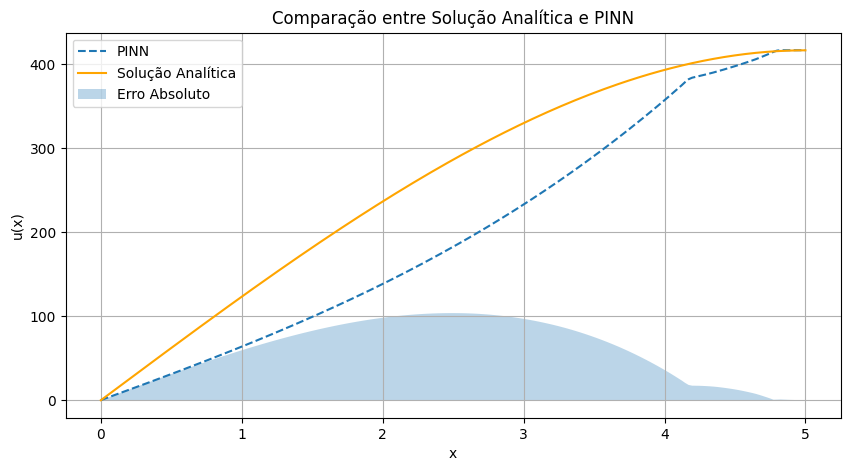

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(x, u_pred, label="PINN", linestyle='--')
plt.plot(x, u_true, label="Solução Analítica", color='orange')
plt.fill_between(x.flatten(), erro.flatten(), alpha=0.3, label="Erro Absoluto")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Comparação entre Solução Analítica e PINN")
plt.legend()
plt.grid(True)
plt.savefig("../imagens/Barra1D_Deslocamento_.png", dpi=300)
plt.show()


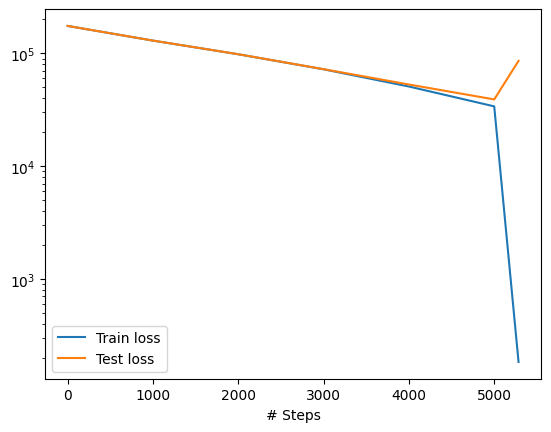

In [7]:
dde.utils.plot_loss_history(losshistory)
plt.savefig("../imagens/Barra1D_Perdaloss.png", dpi=300)
plt.show()
